In [1]:
import os
import sys
import pandas as pd, geopandas as gp, numpy as np
import getpass
from arcgis import GIS

user = getpass.getuser()

DVUTILS_LOCAL_CLONE_PATH = f"/Users/{user}/Documents/GitHub/dvutils"
sys.path.insert(0, DVUTILS_LOCAL_CLONE_PATH)
from utils_io import *

In [14]:
# get census api key
api_key = getpass.getpass(prompt="Enter your Census API key: ")

In [3]:
# authenticate to agol
gis = GIS(url="https://mtc.maps.arcgis.com/home", username="content_MTC")

### Read census api key from file

In [4]:
def get_file_contents(filename):
    """Given a filename,
    return the contents of that file
    """
    try:
        with open(filename, "r") as f:
            # It's assumed our file contains a single line,
            # with our API key
            return f.read().strip()
    except FileNotFoundError:
        print("'%s' file not found" % filename)

In [5]:
def flag_condition_calc(row, df_share_column, standard_deviation):
    cond = (
        df_share_column.mean().round(decimals=2)
        + (standard_deviation * df_share_column.std().round(decimals=2))
    ).round(decimals=2)
    if row > cond:
        return 1
    else:
        return 0

In [6]:
def flag_mult_columns(dataframe, dictionary, standard_deviation):
    for key, value in dictionary.items():
        dataframe[value] = dataframe[key].apply(
            lambda row: flag_condition_calc(row, dataframe[key], standard_deviation)
        )

In [7]:
def set_epc_class(df):
    if df["epc50p_1ha"] == 1:
        return "Highest"
    elif df["epc50p_1"] == 1:
        return "Higher"
    elif df["epc50p_1_2"] == 1:
        return "High"
    else:
        return "NA"

In [8]:
def pull_acs_5_year_est_data(
    census_api_key,
    acs_year=2019,
    tbl_prof_type="Detailed",
    table_id=None,
    select_table_vars=None,
    drop_anno_cols=True,
    drop_margin_cols=True,
):
    """
    Pull American Community Survey (ACS) 5 year estimate data. Data can be pulled for an entire
    table or for select table variables.

    !Must include a table_id or list to select_table_vars parameters!

    Parameters
    -------------------
    census_api_key (String):
    Your secret census api key.

    acs_year (Integer):
    Year for acs estimates, default is 2019 which is latest year 5 year data is available.

    tbl_prof_type (String):
    Table or profile type. These include the following types: Detailed, Subject, Data, or Comparison.

    table_id (String):
    ACS table id. Example 'B01001'

    select_table_vars (List):
    provide a list of ACS table variables as strings. Example: ['B01001_001E','B01001_002E']

    drop_anno_cols (Boolean):
    Used if table_id provided. Drops annotation of margin of error and annotation of estimate
    columns.

    drop_margin_cols (Boolean):
    Used if table_id provided. Drops margin of error columns.

    Returns
    -------------------
    Geodataframe object

    Author: Joshua Croff
    Variable Reference: https://www.census.gov/data/developers/data-sets/acs-5year.html
    """
    import requests
    import pandas as pd

    if table_id:
        var = f"group({table_id})"
    else:
        var = ",".join(select_table_vars)

    counties = "001,013,041,055,075,081,085,095,097"
    state = "06"
    # set base url
    if tbl_prof_type not in ["Detailed", "Subject", "Data", "Comparison"]:
        return "Please provide the following table types: Detailed, Subject, Data, or Comparison"
    elif tbl_prof_type == "Detailed":
        base_url = f"https://api.census.gov/data/{acs_year}/acs/acs5?"
    elif tbl_prof_type == "Subject":
        base_url = f"https://api.census.gov/data/{acs_year}/acs/acs5/subject?"
        # https://api.census.gov/data/2020/acs/acs5/subject?get=NAME,S0101_C01_001E&for=county:037&in=state:06&key=YOUR_KEY_GOES_HERE
    elif tbl_prof_type == "Data":
        base_url = f"https://api.census.gov/data/{acs_year}/acs/acs5/profile?"
    else:
        base_url = f"https://api.census.gov/data/{acs_year}/acs/acs5/cprofile?"

    # set query params
    query_params = {
        "get": var,
        "for": "tract:*",
        "in": [
            f"county:{counties}",
            f"state:{state}",
        ],
        "key": census_api_key,
    }
    rq = requests.get(base_url, params=query_params)
    data = rq.json()
    acs_df = pd.DataFrame(data[1:], columns=data[0])
    # Cast numeric columns to numeric types
    cols = acs_df.columns.to_list()

    if table_id:
        str_cols = ["GEO_ID", "NAME", "state", "county", "tract"]
    else:
        str_cols = ["state", "county", "tract"]
    num_cols = list(set(cols) - set(str_cols))
    acs_df[num_cols] = acs_df[num_cols].apply(pd.to_numeric)

    # Drop annotation columns
    if drop_anno_cols:
        acs_df = acs_df.loc[
            :, ~((acs_df.columns.str.endswith("EA")) | (acs_df.columns.str.endswith("MA")))
        ].copy()

    if drop_margin_cols:
        acs_df = acs_df.loc[:, ~acs_df.columns.str.endswith("M").copy()]

    # add tract id column
    acs_df["tract_geoid"] = acs_df["state"] + acs_df["county"] + acs_df["tract"]

    # rename columns
    acs_df = acs_df.rename(columns={"county": "fipco"})

    # drop redundent columns
    if table_id:
        acs_df = acs_df.drop(columns=["GEO_ID", "NAME", "state", "tract"])
    else:
        acs_df = acs_df.drop(columns=["state", "tract"])

    return acs_df

In [9]:
def pull_census_tracts_geodata(year=2020, cartographic=False):
    """
    Pulls Census Tracts from TIGERweb REST API and returns Geopandas GeoDataframe.
    Default year is 2020 which is the latest-available vintage for TIGER tracts.

    How to choose vintage: https://www2.census.gov/geo/pdfs/maps-data/data/tiger/How_do_I_choose_TIGER_vintage.pdf

    Parameters
    -------------------
    year (int):
    the TIGER vintage.
    list of valid years: [2012,2015,2016,2017,2018,2019,2020]

    catrographic (bool):
    If the cartographic parameter is set to true, a generalized version of tracts is returned
    with water areas clipped.

    Author: Joshua Croff
    Source: https://tigerweb.geo.census.gov/tigerwebmain/TIGERweb_restmapservice.html
    """
    import geopandas as gpd
    import requests

    valid_years = [2012, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
    pre_2020 = [2012, 2015, 2016, 2017, 2018, 2019]
    if year not in valid_years:
        print("Error- vintage not available. Please see docstring for valid years")
        return

    if year == 2020 and cartographic == True:
        map_service = f"Generalized_TAB{year}"
    elif year == 2020:
        map_service = f"tigerWMS_Census{year}"
        layer_id = "6"
    elif year in pre_2020 and cartographic == True:
        map_service = f"Generalized_ACS{year}"
    elif year in pre_2020:
        map_service = f"tigerWMS_ACS{year}"
        layer_id = "8"
    elif year > 2020 and cartographic == True:
        map_service = f"Generalized_ACS{year}"
    else:
        map_service = f"tigerWMS_ACS{year}"
        layer_id = "6"

    state = "06"
    counties = "('001','013','041','055','075','081','085','095','097')"
    where_str = f"where=STATE='{state}'+AND+COUNTY+IN{counties}"
    query_args = [where_str, "outFields=GEOID&f=geojson"]

    if cartographic:
        url = "/".join(
            [
                "https://tigerweb.geo.census.gov",
                "arcgis",
                "rest",
                "services",
                map_service,
                "Tracts_Blocks",
                "MapServer",
                "3",
                "query?{}".format("&".join(query_args)),
            ]
        )
    else:
        url = "/".join(
            [
                "https://tigerweb.geo.census.gov",
                "arcgis",
                "rest",
                "services",
                "TIGERweb",
                map_service,
                "MapServer",
                layer_id,
                "query?{}".format("&".join(query_args)),
            ]
        )
    r = requests.get(url)
    geog_json = r.json()
    geog_gdf = gpd.GeoDataFrame.from_features(geog_json["features"], crs="EPSG:4326")

    # rename GEOID column to tract_geoid
    geog_gdf = geog_gdf.rename(columns={"GEOID": "tract_geoid"})
    return geog_gdf

### Read selected ACS varibles from csv

In [10]:
acs_epc_selected_vars = pd.read_csv("Data/acs_table_variables_epc_factors.csv")

In [11]:
acs_vars_lst = acs_epc_selected_vars["ACS_Table_Variable"].tolist()

### Query ACS API
#### [Census American Community Survey 5-Year Data API Documentation](https://www.census.gov/data/developers/data-sets/acs-5year.html)

In [15]:
# pull american community survey tabular data
acs_df = pull_acs_5_year_est_data(
    census_api_key=api_key, acs_year=2021, tbl_prof_type="Detailed", select_table_vars=acs_vars_lst
)

In [16]:
# pull american community survey geographic data
acs_gdf = pull_census_tracts_geodata(year=2021, cartographic=True)

In [17]:
acs_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
water_area = gpd.read_file(
    "https://services3.arcgis.com/i2dkYWmb4wHvYPda/arcgis/rest/services/region_water_area/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson",
    driver="GeoJSON",
)

### Rename columns for consistancy with prior epcs

In [15]:
cols = {
    "fipco": "county_fip",
    "B03002_001E": "tot_pop_mi",
    "B01001_001E": "tot_pop_se",
    "C17002_001E": "tot_pop_po",
    "C18108_001E": "tot_pop_ci",
    "B08201_001E": "tot_hh",
    "B11004_001E": "tot_fam",
    "B16005_001E": "tot_pop_ov",
    "B25070_010E": "pop_hus_re",
    "B08201_002E": "pop_zvhhs",
}
acs_df.rename(columns=cols, inplace=True)

### Calculate epc and populations

In [16]:
# calculate minority population
acs_df["pop_minori"] = acs_df["tot_pop_mi"] - acs_df["B03002_003E"]

# calculate senior population
acs_df["pop_over75"] = (
    acs_df["B01001_023E"]
    + acs_df["B01001_024E"]
    + acs_df["B01001_025E"]
    + acs_df["B01001_047E"]
    + acs_df["B01001_048E"]
    + acs_df["B01001_049E"]
)

# calculate single parent family population
acs_df["pop_spfam"] = acs_df["B11004_010E"] + acs_df["B11004_016E"]

# calculate limited english proficiency population
acs_df["pop_lep"] = (
    acs_df["B16005_007E"]
    + acs_df["B16005_008E"]
    + acs_df["B16005_012E"]
    + acs_df["B16005_013E"]
    + acs_df["B16005_017E"]
    + acs_df["B16005_018E"]
    + acs_df["B16005_022E"]
    + acs_df["B16005_023E"]
    + acs_df["B16005_029E"]
    + acs_df["B16005_030E"]
    + acs_df["B16005_034E"]
    + acs_df["B16005_035E"]
    + acs_df["B16005_039E"]
    + acs_df["B16005_040E"]
    + acs_df["B16005_044E"]
    + acs_df["B16005_045E"]
)

# calculate population below 200% of poverty
acs_df["pop_below2"] = acs_df["tot_pop_po"] - acs_df["C17002_008E"]

# calculate population with a disability
acs_df["pop_disabi"] = acs_df["tot_pop_ci"] - (
    acs_df["C18108_005E"] + acs_df["C18108_009E"] + acs_df["C18108_013E"]
)

### Calculate epc shares

In [17]:
acs_df["pct_minori"] = np.where(
    acs_df["tot_pop_mi"] == 0, 0, (acs_df["pop_minori"] / acs_df["tot_pop_mi"])
)
acs_df["pct_over75"] = np.where(
    acs_df["tot_pop_se"] == 0, 0, (acs_df["pop_over75"] / acs_df["tot_pop_se"])
)
acs_df["pct_spfam"] = np.where(acs_df["tot_fam"] == 0, 0, (acs_df["pop_spfam"] / acs_df["tot_fam"]))
acs_df["pct_lep"] = np.where(
    acs_df["tot_pop_ov"] == 0, 0, (acs_df["pop_lep"] / acs_df["tot_pop_ov"])
)
acs_df["pct_below2"] = np.where(
    acs_df["tot_pop_po"] == 0, 0, (acs_df["pop_below2"] / acs_df["tot_pop_po"])
)
acs_df["pct_disab"] = np.where(
    acs_df["tot_pop_ci"] == 0, 0, (acs_df["pop_disabi"] / acs_df["tot_pop_ci"])
)
acs_df["pct_zvhhs"] = np.where(acs_df["tot_hh"] == 0, 0, (acs_df["pop_zvhhs"] / acs_df["tot_hh"]))
acs_df["pct_hus_re"] = np.where(acs_df["tot_hh"] == 0, 0, (acs_df["pop_hus_re"] / acs_df["tot_hh"]))

### Flag epcs and epc levels (high, higher, highest) 

### Flag halfsd columns and count factors

In [18]:
cols_dict_halfsd = {
    "pct_over75": "over75_1_2",
    "pct_minori": "minori_1_2",
    "pct_spfam": "spfam_1_2",
    "pct_disab": "disab_1_2",
    "pct_lep": "lep_1_2",
    "pct_below2": "below2_1_2",
    "pct_zvhhs": "zvhh_1_2",
    "pct_hus_re": "hus_re_1_2",
}

flag_mult_columns(acs_df, cols_dict_halfsd, 0.5)

In [19]:
halfsd_cols_list = [
    "below2_1_2",
    "minori_1_2",
    "spfam_1_2",
    "disab_1_2",
    "lep_1_2",
    "over75_1_2",
    "zvhh_1_2",
    "hus_re_1_2",
]
acs_df["count_1_2"] = acs_df[halfsd_cols_list].sum(axis=1)

### Flag halfsd epc

In [20]:
halfsd_remain = ["spfam_1_2", "disab_1_2", "lep_1_2", "over75_1_2", "zvhh_1_2", "hus_re_1_2"]
halfsd_cond = ((acs_df["minori_1_2"] == 1) & (acs_df["below2_1_2"] == 1)) | (
    (acs_df["below2_1_2"] == 1) & (acs_df[halfsd_remain].sum(axis=1) >= 3)
)
acs_df["epc50p_1_2"] = np.where(halfsd_cond, 1, 0)

### Flag onesd columns

In [21]:
cols_dict_onesd = {
    "pct_over75": "over75_1",
    "pct_minori": "minori_1",
    "pct_spfam": "spfam_1",
    "pct_disab": "disab_1",
    "pct_lep": "lep_1",
    "pct_below2": "below2_1",
    "pct_zvhhs": "zvhh_1",
    "pct_hus_re": "hus_re_1",
}

flag_mult_columns(acs_df, cols_dict_onesd, 1)

In [22]:
onesd_cols_list = [
    "below2_1",
    "minori_1",
    "spfam_1",
    "disab_1",
    "lep_1",
    "over75_1",
    "zvhh_1",
    "hus_re_1",
]
acs_df["count_1"] = acs_df[onesd_cols_list].sum(axis=1)

### Flag onesd epc

In [23]:
onesd_remain = ["spfam_1", "disab_1", "lep_1", "over75_1", "zvhh_1", "hus_re_1"]
onesd_cond = ((acs_df["minori_1"] == 1) & (acs_df["below2_1"] == 1)) | (
    (acs_df["below2_1"] == 1) & (acs_df[onesd_remain].sum(axis=1) >= 3)
)
acs_df["epc50p_1"] = np.where(onesd_cond, 1, 0)

### Flag onehalfsd columns

In [24]:
cols_dict_onehalfsd = {
    "pct_over75": "over75_1ha",
    "pct_minori": "minori_1ha",
    "pct_spfam": "spfam_1ha",
    "pct_disab": "disab_1ha",
    "pct_lep": "lep_1ha",
    "pct_below2": "below2_1ha",
    "pct_zvhhs": "zvhh_1ha",
    "pct_hus_re": "hus_re_1ha",
}

flag_mult_columns(acs_df, cols_dict_onehalfsd, 1.5)

In [25]:
onehalfsd_cols_list = [
    "below2_1ha",
    "minori_1ha",
    "spfam_1ha",
    "disab_1ha",
    "lep_1ha",
    "over75_1ha",
    "zvhh_1ha",
    "hus_re_1ha",
]
acs_df["count_1ha"] = acs_df[onehalfsd_cols_list].sum(axis=1)

### Flag onehalfsd epc

In [26]:
onehalfsd_remain = ["spfam_1ha", "disab_1ha", "lep_1ha", "over75_1ha", "zvhh_1ha", "hus_re_1ha"]
onehalfsd_cond = ((acs_df["minori_1ha"] == 1) & (acs_df["below2_1ha"] == 1)) | (
    (acs_df["below2_1ha"] == 1) & (acs_df[onehalfsd_remain].sum(axis=1) >= 3)
)
acs_df["epc50p_1ha"] = np.where(onehalfsd_cond, 1, 0)

### Flag 2050 epcs

In [27]:
acs_df["epc_2050p"] = np.where(
    (acs_df["epc50p_1ha"] == 1) | (acs_df["epc50p_1"] == 1) | (acs_df["epc50p_1_2"]), 1, 0
)

### Create epc classes

In [28]:
acs_df["epc_class"] = acs_df.apply(set_epc_class, axis=1)

In [29]:
acs_df.groupby("epc_class")["epc_2050p"].agg(sum)

epc_class
High       152
Higher     101
Highest     60
NA           0
Name: epc_2050p, dtype: int64

## Compare previous EPCs

In [30]:
census_vintage_crosswalk = pd.read_csv(
    "https://www2.census.gov/geo/docs/maps-data/data/rel2020/tract/tab20_tract20_tract10_natl.txt",
    sep="|",
    dtype=str,
)

In [31]:
census_vintage_crosswalk.rename(
    columns={"GEOID_TRACT_20": "tract_geoid20", "GEOID_TRACT_10": "tract_geoid10"}, inplace=True
)

In [32]:
pba50_epc_df = pull_geotable_agol(
    base_url="https://services3.arcgis.com/i2dkYWmb4wHvYPda/arcgis/rest/services/communities_of_concern_2020_acs2018/FeatureServer/0",
    client=gis,
    reproject_to_analysis_crs=False,
)

Breaking feature service layer IDs into 8 chunks


In [33]:
pba50_epc_df.rename(columns={"geoid": "tract_geoid10"}, inplace=True)

In [34]:
pba50_epc_df["epc_2050"].sum()

343

In [35]:
pba50_epc_cross = pd.merge(
    pba50_epc_df[["tract_geoid10", "epc_2050", "geometry"]],
    census_vintage_crosswalk[["tract_geoid20", "tract_geoid10"]],
    on="tract_geoid10",
    how="left",
)

In [36]:
acs_df.rename(columns={"tract_geoid": "tract_geoid20"}, inplace=True)

In [37]:
# update acs_df with epc_2050 values
acs_df["epc_2050"] = acs_df["tract_geoid20"].map(
    pba50_epc_cross.sort_values(by="epc_2050", ascending=False)
    .groupby("tract_geoid20")["epc_2050"]
    .first()
)

### Sum pba2050 and pba2040 epcs for comparison

In [38]:
acs_df[["epc_2050", "epc_2050p"]].sum()

epc_2050     466.0
epc_2050p    313.0
dtype: float64

### Calculate epc gains and losses by tract for pba50 and pba2050 +

In [39]:
acs_df.loc[acs_df["epc_2050"].isnull(), "epc_2050"] = 0

In [40]:
acs_df["c2050_2050p"] = acs_df["epc_2050p"] - acs_df["epc_2050"]

## Calculate regional statistics 

In [41]:
epc_region_stats = (
    acs_df.agg(
        {
            "pct_over75": ["mean", "std"],
            "pct_minori": ["mean", "std"],
            "pct_lep": ["mean", "std"],
            "pct_spfam": ["mean", "std"],
            "pct_below2": ["mean", "std"],
            "pct_disab": ["mean", "std"],
            "pct_zvhhs": ["mean", "std"],
            "pct_hus_re": ["mean", "std"],
        }
    )
    .transpose()
    .reset_index()
)

In [42]:
epc_region_stats.rename(columns={"index": "factors"}, inplace=True)

In [43]:
epc_factors = {
    "pct_over75": "Seniors 75 Years and Over",
    "pct_minori": "Minorities",
    "pct_lep": "Limited English Proficiency",
    "pct_spfam": "Single Parent Families",
    "pct_below2": "Low-Income (<200% Federal Poverty Level-FPL)",
    "pct_disab": "People with Disability",
    "pct_zvhhs": "Zero-Vehicle Household",
    "pct_hus_re": "Rent-Burdened",
}
epc_region_stats["factors"].replace(epc_factors, inplace=True)

In [44]:
epc_region_stats["mean"] = epc_region_stats["mean"].round(decimals=2)
epc_region_stats["std"] = epc_region_stats["std"].round(decimals=2)

### Create fields for .5, 1, and 1.5 sd from mean

In [45]:
epc_region_stats["plus_half_sd"] = (
    epc_region_stats["mean"] + (0.5 * epc_region_stats["std"])
).round(decimals=2)
epc_region_stats["plus_one_sd"] = (epc_region_stats["mean"] + epc_region_stats["std"]).round(
    decimals=2
)
epc_region_stats["plus_one_half_sd"] = (
    epc_region_stats["mean"] + (1.5 * epc_region_stats["std"])
).round(decimals=2)

In [46]:
epc_region_stats

,factors,mean,std,plus_half_sd,plus_one_sd,plus_one_half_sd
0,Seniors 75 Years and Over,0.07,0.05,0.10,0.12,0.15
1,Minorities,0.60,0.23,0.72,0.83,0.94
2,Limited English Proficiency,0.07,0.08,0.11,0.15,0.19
3,Single Parent Families,0.12,0.09,0.16,0.21,0.26
4,Low-Income (<200% Federal Poverty Level-FPL),0.19,0.13,0.26,0.32,0.38
5,People with Disability,0.10,0.05,0.12,0.15,0.18
6,Zero-Vehicle Household,0.09,0.14,0.16,0.23,0.30
7,Rent-Burdened,0.10,0.08,0.14,0.18,0.22


In [47]:
epc_region_stats.to_csv("Data/epc_regional_stats_ACS2021.csv", index=False)

## Join census tracts geo to epc df

In [48]:
acs_df.rename(columns={"tract_geoid20": "tract_geoid"}, inplace=True)

In [49]:
epc_gdf = pd.merge(acs_gdf, acs_df, on="tract_geoid", how="inner")

In [50]:
# # clip to water areas
# epc_erase_gdf = gpd.overlay(epc_gdf, water_area, how="difference")

In [51]:
# epc_erase_gdf.explore()

In [72]:
final_cols = [
    "tract_geoid",
    "county_fip",
    "tot_pop_mi",
    "tot_pop_se",
    "tot_pop_po",
    "tot_pop_ci",
    "tot_hh",
    "pop_zvhhs",
    "tot_fam",
    "tot_pop_ov",
    "pop_hus_re",
    "pop_minori",
    "pop_over75",
    "pop_spfam",
    "pop_lep",
    "pop_below2",
    "pop_disabi",
    "pct_minori",
    "pct_over75",
    "pct_spfam",
    "pct_lep",
    "pct_below2",
    "pct_disab",
    "pct_zvhhs",
    "pct_hus_re",
    "over75_1_2",
    "minori_1_2",
    "spfam_1_2",
    "disab_1_2",
    "lep_1_2",
    "below2_1_2",
    "zvhh_1_2",
    "hus_re_1_2",
    "epc_2050p",
    "epc_class",
    "epc_2050",
    "c2050_2050p",
    "geometry",
]
epc_path = "Data/epc_acs2021.geojson"
epc_gdf[final_cols].to_file(epc_path, driver="GeoJSON")

## Explore changes in geog

In [53]:
pba50_epc_cross.query("tract_geoid10 =='06013307205'")

,tract_geoid10,epc_2050,geometry,tract_geoid20
2547,06013307205,1,"POLYGON ((-121.85371 37.98550, -121.85291 37.9...",06013307205
2548,06013307205,1,"POLYGON ((-121.85371 37.98550, -121.85291 37.9...",06013355107


In [54]:
pba50_epc_cross.query("tract_geoid20 == '06013355107'")

,tract_geoid10,epc_2050,geometry,tract_geoid20
578,06013355306,0,"POLYGON ((-121.98946 37.89978, -121.98154 37.9...",06013355107
581,06013355304,0,"POLYGON ((-121.95734 37.95211, -121.95467 37.9...",06013355107
646,06013355107,0,"POLYGON ((-121.92478 37.95806, -121.92372 37.9...",06013355107
661,06013355109,0,"POLYGON ((-121.80566 37.98249, -121.80273 37.9...",06013355107
862,06013307101,0,"POLYGON ((-121.82414 37.98504, -121.82285 37.9...",06013355107
2548,06013307205,1,"POLYGON ((-121.85371 37.98550, -121.85291 37.9...",06013355107


In [55]:
census_vintage_crosswalk.query("tract_geoid20 == '06013355107'")

,OID_TRACT_20,tract_geoid20,NAMELSAD_TRACT_20,AREALAND_TRACT_20,AREAWATER_TRACT_20,MTFCC_TRACT_20,FUNCSTAT_TRACT_20,OID_TRACT_10,tract_geoid10,NAMELSAD_TRACT_10,AREALAND_TRACT_10,AREAWATER_TRACT_10,MTFCC_TRACT_10,FUNCSTAT_TRACT_10,AREALAND_PART,AREAWATER_PART
7616,207903717106540,06013355107,Census Tract 3551.07,82054530,498136,G5020,S,20740146182631,06013307101,Census Tract 3071.01,2132789,0,G5020,S,652,0
7617,207903717106540,06013355107,Census Tract 3551.07,82054530,498136,G5020,S,20740146182498,06013307205,Census Tract 3072.05,3076555,0,G5020,S,22347,0
7618,207903717106540,06013355107,Census Tract 3551.07,82054530,498136,G5020,S,207403717106540,06013355107,Census Tract 3551.07,81989507,498136,G5020,S,81971676,498136
7619,207903717106540,06013355107,Census Tract 3551.07,82054530,498136,G5020,S,207403717106952,06013355109,Census Tract 3551.09,3040699,0,G5020,S,56483,0
7620,207903717106540,06013355107,Census Tract 3551.07,82054530,498136,G5020,S,20740146183297,06013355304,Census Tract 3553.04,9814154,0,G5020,S,17,0
7621,207903717106540,06013355107,Census Tract 3551.07,82054530,498136,G5020,S,207403717106994,06013355306,Census Tract 3553.06,67168115,5020,G5020,S,3355,0


In [56]:
# pba50_epc_cross.query("tract_geoid10 =='06013307205'").explore()

In [57]:
m = pba50_epc_cross.query("tract_geoid10 == '06013307205'").explore()
epc_gdf.query("tract_geoid == '06013355107'").explore(m=m, color="red")

In [58]:
pba50_epc_cross.query("tract_geoid10 =='06013336101'")

,tract_geoid10,epc_2050,geometry,tract_geoid20
2581,06013336101,1,"POLYGON ((-122.03730 37.97333, -122.03601 37.9...",06013328000
2582,06013336101,1,"POLYGON ((-122.03730 37.97333, -122.03601 37.9...",06013336101
2583,06013336101,1,"POLYGON ((-122.03730 37.97333, -122.03601 37.9...",06013337100
2584,06013336101,1,"POLYGON ((-122.03730 37.97333, -122.03601 37.9...",06013337202


In [59]:
pba50_epc_cross.query("tract_geoid20 == '06013337202'")

,tract_geoid10,epc_2050,geometry,tract_geoid20
762,06013337100,0,"POLYGON ((-122.03111 37.96835, -122.02331 37.9...",06013337202
777,06013337200,0,"POLYGON ((-122.03897 37.95637, -122.03568 37.9...",06013337202
2584,06013336101,1,"POLYGON ((-122.03730 37.97333, -122.03601 37.9...",06013337202


In [60]:
m = pba50_epc_cross.query("tract_geoid10 == '06013336101'").explore()
epc_gdf.query("tract_geoid == '06013337202'").explore(m=m, color="red")

In [61]:
pba50_epc_cross.query("tract_geoid10 =='06001422000'")

,tract_geoid10,epc_2050,geometry,tract_geoid20
2255,06001422000,1,"POLYGON ((-122.32519 37.87428, -122.31866 37.8...",06001400800
2256,06001422000,1,"POLYGON ((-122.32519 37.87428, -122.31866 37.8...",06001420401
2257,06001422000,1,"POLYGON ((-122.32519 37.87428, -122.31866 37.8...",06001420402
2258,06001422000,1,"POLYGON ((-122.32519 37.87428, -122.31866 37.8...",06001422000
2259,06001422000,1,"POLYGON ((-122.32519 37.87428, -122.31866 37.8...",06001425102
2260,06001422000,1,"POLYGON ((-122.32519 37.87428, -122.31866 37.8...",06001425103


In [62]:
pba50_epc_cross.query("tract_geoid20 =='06001420402'")

,tract_geoid10,epc_2050,geometry,tract_geoid20
286,06001420300,0,"POLYGON ((-122.32691 37.89249, -122.31544 37.8...",06001420402
323,06001420400,0,"POLYGON ((-122.32691 37.88965, -122.31232 37.8...",06001420402
2257,06001422000,1,"POLYGON ((-122.32519 37.87428, -122.31866 37.8...",06001420402


In [63]:
m = pba50_epc_cross.query("tract_geoid10 == '06001422000'").explore()
epc_gdf[["tract_geoid",'c2050_2050p',"geometry"]].query("tract_geoid == '06001420402'").explore(m=m, color="red")

In [64]:
pba50_epc_cross.query("tract_geoid10 =='06075023001'")

,tract_geoid10,epc_2050,geometry,tract_geoid20
2713,06075023001,1,"POLYGON ((-122.40685 37.73805, -122.39969 37.7...",06075023001
2714,06075023001,1,"POLYGON ((-122.40685 37.73805, -122.39969 37.7...",06075980900


In [65]:
pba50_epc_cross.query("tract_geoid20 =='06075980900'")

,tract_geoid10,epc_2050,geometry,tract_geoid20
1068,06075980900,0,"POLYGON ((-122.40695 37.74050, -122.40459 37.7...",06075980900
1178,06075025100,0,"POLYGON ((-122.41066 37.74242, -122.40938 37.7...",06075980900
2714,06075023001,1,"POLYGON ((-122.40685 37.73805, -122.39969 37.7...",06075980900


In [66]:
m = pba50_epc_cross.query("tract_geoid10 == '06075023001'").explore()
epc_gdf[["tract_geoid",'c2050_2050p',"geometry"]].query("tract_geoid.isin(['06075023001','06075980900'])").explore(m=m, color="red")

## Publish to arcgis online

In [67]:
# # Add item to ArcGIS Online
# item_properties = {
#     "type": "GeoJson",
#     "description": "This data set represents tract information related to Equity Priority Communities for Plan Bay Area 2050 +. The data set was developed using American Community Survey 2017-2021 data for eight variables considered.",
#     "title": "DRAFT Equity Priority Communities - Plan Bay Area 2050 +",
#     "tags": "bay area, equity, policy, planning, environmental justice, acs, american community survey, epc, community of concern",
#     "overwrite": True,
# }
# item = gis.content.add(item_properties, data=epc_path, folder="plan_policy")

In [68]:
# # Publish item as feature service
# item.publish(file_type="geojson")

In [78]:
# Get published feature service feature layer id
flid = "68eb6442d92143caaa9766855bff296d"
fl = gis.content.get(flid)

<Item title:"DRAFT Equity Priority Communities - Plan Bay Area 2050" type:Feature Layer Collection owner:content_MTC>
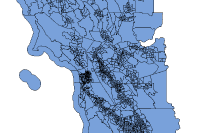

In [79]:
fl

In [80]:
# overwrite feature service
from arcgis.features import FeatureLayerCollection

flc = FeatureLayerCollection.fromitem(fl)
flc.manager.overwrite(epc_path)

Exception: User cannot overwrite this service, using this data, as this data is already referring to another service.
(Error Code: 500)

### Create Field Map Dictionary to Rename Feature Class Alias

In [ ]:
field_metadata = pd.read_csv("Data/EPC_Schema_pba2050p.csv")

In [ ]:
field_metadata.head(5)

In [ ]:
dict(zip(field_metadata["Field Name"], field_metadata["Alias"]))